In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import imageio
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

In [2]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


C:\Users\mamat\AppData\Local\Temp/ipykernel_12816/4181138602.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(np.fromstring(data['pixels'][0], dtype=np.int, sep=' ').reshape(48,48) , cmap='gray')


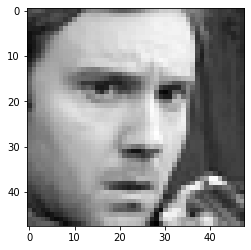

In [3]:
plt.imshow(np.fromstring(data['pixels'][0], dtype=np.int, sep=' ').reshape(48,48) , cmap='gray')
plt.show()

In [4]:
data.shape

(35887, 3)

In [5]:
X = []
for pic in tqdm(data['pixels']):
    arr = list(np.fromstring(pic, dtype=np.int64, sep=' '))
    X.append(arr)
X = np.array(X)
X

100%|██████████████████████████████████████████████████████████████████████████| 35887/35887 [00:19<00:00, 1860.71it/s]


array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 17,  17,  16, ..., 154, 133, 113],
       [ 30,  28,  28, ...,  35,  30,  28],
       [ 19,  13,  14, ..., 189, 199, 201]], dtype=int64)

In [6]:
y = data['emotion']
y

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

### Normalize Data

In [7]:
# Normalize
X = X/255.0
X.shape

(35887, 2304)

### Use PCA

In [8]:
pca = PCA(n_components=min(X.shape[0], X.shape[1]))
faces_pca = pca.fit_transform(X)

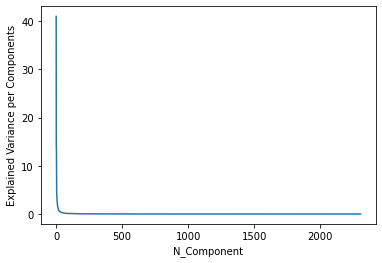

In [9]:
# The amount of variance explained by each of the selected components
plt.plot(pca.explained_variance_)
plt.ylabel('Explained Variance per Components')
plt.xlabel('N_Component')
plt.show()

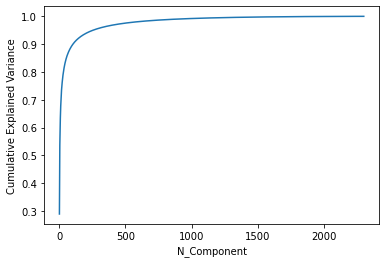

In [10]:
# Percentage of variance explained by each of the selected components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('N_Component')
plt.show()

In [11]:
pca.explained_variance_[0:4]

array([40.98614679, 13.88906504, 13.35509333,  7.80055946])

In [12]:
pca.explained_variance_[-4:]

array([7.12863353e-05, 6.59873093e-05, 6.42142819e-05, 5.92781652e-05])

In [13]:
var = np.cumsum(pca.explained_variance_ratio_)
best_dim = next(x for x, val in enumerate(var) if val > 0.99)
print(best_dim)

886


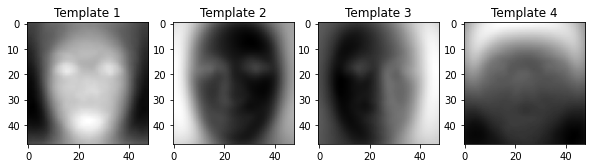

In [14]:
basis = pca.components_.T.reshape(48, 48, X.shape[1])
plt.figure(figsize=(10, 15))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(basis[:,:,i], 'gray')
    plt.title('Template {}'.format(i+1))

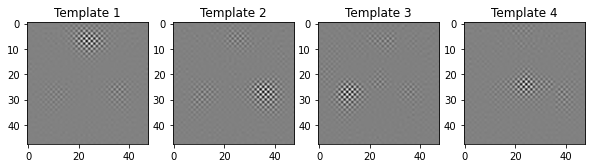

In [15]:
basis = pca.components_.T.reshape(48, 48, X.shape[1])
plt.figure(figsize=(10, 15))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(basis[:,:,-(i+1)], 'gray')
    plt.title('Template {}'.format(i+1))

In [16]:
pca_opt = PCA(n_components = 200)
X_new = pca_opt.fit_transform(X)

In [17]:
X.shape

(35887, 2304)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y, test_size=0.33, random_state=42)

In [19]:
# k = 1 on PCA
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_new, y)

accuracy = cross_val_score(clf, X_new, y, cv=10 , scoring='accuracy')
print('CV Accuracy: ', np.mean(accuracy), '\n') 
print(30*'=')
y_pred = cross_val_predict(clf, X_new, y, cv=10)
print('Classification Report: \n')
print(classification_report(y, y_pred))
print(30*'=')
print('\nConfusion matrix: ')
print(pd.DataFrame(confusion_matrix(y, y_pred)))

CV Accuracy:  0.4159448711891563 

Classification Report: 

              precision    recall  f1-score   support

           0       0.39      0.34      0.36      4953
           1       0.39      0.58      0.47       547
           2       0.42      0.40      0.41      5121
           3       0.46      0.43      0.44      8989
           4       0.36      0.33      0.34      6077
           5       0.59      0.63      0.61      4002
           6       0.33      0.41      0.36      6198

    accuracy                           0.42     35887
   macro avg       0.42      0.44      0.43     35887
weighted avg       0.42      0.42      0.42     35887


Confusion matrix: 
      0    1     2     3     4     5     6
0  1661   80   517   908   576   267   944
1    39  315    28    50    38    23    54
2   454   51  2070   755   686   367   738
3   771  141   715  3862  1118   504  1878
4   596   92   727  1189  1984   266  1223
5   163   34   300   422   226  2507   350
6   566   87   603  12

In [20]:
# k = 1 on TOTAL
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

accuracy = cross_val_score(clf, X, y, cv=10 , scoring='accuracy')
print('CV Accuracy: ', np.mean(accuracy), '\n') 
print(30*'=')
y_pred = cross_val_predict(clf, X, y, cv=10)
print('Classification Report: \n')
print(classification_report(y, y_pred))
print(30*'=')
print('\nConfusion matrix: ')
print(pd.DataFrame(confusion_matrix(y, y_pred)))

CV Accuracy:  0.4073622781489209 

Classification Report: 

              precision    recall  f1-score   support

           0       0.39      0.32      0.35      4953
           1       0.39      0.57      0.46       547
           2       0.41      0.40      0.40      5121
           3       0.45      0.40      0.42      8989
           4       0.36      0.33      0.34      6077
           5       0.61      0.61      0.61      4002
           6       0.32      0.43      0.36      6198

    accuracy                           0.41     35887
   macro avg       0.42      0.44      0.42     35887
weighted avg       0.41      0.41      0.41     35887


Confusion matrix: 
      0    1     2     3     4     5     6
0  1592   85   514   872   619   240  1031
1    40  311    35    50    39    20    52
2   456   49  2032   756   685   322   821
3   735  141   752  3610  1202   422  2127
4   580   86   719  1144  1998   265  1285
5   162   37   287   438   234  2437   407
6   534   85   602  12

In [21]:
# k = 2 on PCA
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_new, y)

accuracy = cross_val_score(clf, X_new, y, cv=10 , scoring='accuracy')
print('CV Accuracy: ', np.mean(accuracy), '\n') 
print(30*'=')
y_pred = cross_val_predict(clf, X_new, y, cv=10)
print('Classification Report: \n')
print(classification_report(y, y_pred))
print(30*'=')
print('\nConfusion matrix: ')
print(pd.DataFrame(confusion_matrix(y, y_pred)))

CV Accuracy:  0.3654808154359925 

Classification Report: 

              precision    recall  f1-score   support

           0       0.29      0.42      0.34      4953
           1       0.25      0.56      0.35       547
           2       0.32      0.44      0.37      5121
           3       0.41      0.46      0.43      8989
           4       0.33      0.23      0.27      6077
           5       0.59      0.44      0.50      4002
           6       0.41      0.18      0.25      6198

    accuracy                           0.37     35887
   macro avg       0.37      0.39      0.36     35887
weighted avg       0.38      0.37      0.36     35887


Confusion matrix: 
      0    1     2     3     4     5     6
0  2086  116   746  1071   453   177   304
1    74  305    45    62    20    20    21
2   881  108  2240   956   477   229   230
3  1534  257  1283  4178   811   312   614
4  1186  165  1130  1599  1417   186   394
5   406   81   651   689   318  1755   102
6  1101  165  1016  17

In [22]:
# k = 2 on TOTAL
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X, y)

accuracy = cross_val_score(clf, X, y, cv=10 , scoring='accuracy')
print('CV Accuracy: ', np.mean(accuracy), '\n') 
print(30*'=')
y_pred = cross_val_predict(clf, X, y, cv=10)
print('Classification Report: \n')
print(classification_report(y, y_pred))
print(30*'=')
print('\nConfusion matrix: ')
print(pd.DataFrame(confusion_matrix(y, y_pred)))

CV Accuracy:  0.36336300096945545 

Classification Report: 

              precision    recall  f1-score   support

           0       0.29      0.41      0.34      4953
           1       0.25      0.56      0.34       547
           2       0.31      0.44      0.36      5121
           3       0.41      0.46      0.43      8989
           4       0.32      0.24      0.27      6077
           5       0.59      0.43      0.50      4002
           6       0.39      0.20      0.26      6198

    accuracy                           0.36     35887
   macro avg       0.37      0.39      0.36     35887
weighted avg       0.38      0.36      0.36     35887


Confusion matrix: 
      0    1     2     3     4     5     6
0  2020  125   743  1059   477   175   354
1    78  304    53    55    18    17    22
2   857  111  2232   937   501   219   264
3  1429  270  1327  4094   858   319   692
4  1150  170  1147  1554  1432   200   424
5   380   88   632   689   349  1738   126
6  1055  159  1018  1

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [23:20<00:00, 58.37s/it]


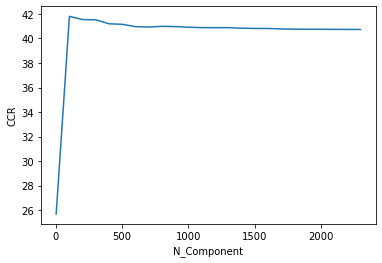

In [23]:
clf = KNeighborsClassifier(n_neighbors=1)
acc, n_comp = list(), list()
for comp in tqdm(range(1, X.shape[1], 100)):
  pca = PCA(n_components = comp)
  X_fit = pca.fit_transform(X)
  clf.fit(X_fit, y)
  scores = cross_val_score(clf, X_fit, y, cv=10 , scoring='accuracy')
  acc.append(np.mean(scores)*100)
  n_comp.append(comp)
    
plt.plot(n_comp, acc)
plt.ylabel('CCR')
plt.xlabel('N_Component')
plt.show()